New Notebook


In [620]:
import importFunctions as imp 
import kagglehub

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

import pandas as pd


path = kagglehub.dataset_download("fantineh/next-day-wildfire-spread")
print("Path to dataset files:", path)

train_files = path + "/next_day_wildfire_spread_train*"
test_files = path + "/next_day_wildfire_spread_test*"
eval_files = path + "/next_day_wildfire_spread_eval*"


train = imp.get_dataset(train_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)


eval_data = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

Path to dataset files: C:\Users\theco\.cache\kagglehub\datasets\fantineh\next-day-wildfire-spread\versions\2


In [621]:
#function to plot rows of the train data
def plotRows(start,end,titles,n_features,data):
  inputs, labels = next(iter(data))

  fig = plt.figure(figsize=(15,6.5))

  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

  n_rows = end-start
  for i in range(n_rows):
    for j in range(n_features + 1):
      plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
      if i == 0:
        plt.title(titles[j], fontsize=13)
      if j < n_features - 1:
        plt.imshow(inputs[i+start, :, :, j], cmap='viridis')
      if j == n_features - 1:
        plt.imshow(inputs[i+start, :, :, -1], cmap=CMAP, norm=NORM)
      if j == n_features:
        plt.imshow(labels[i+start, :, :, 0], cmap=CMAP, norm=NORM) 
      plt.axis('off')
  plt.tight_layout()

  plt.show()

In [622]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# plotRows(20,25,titles,len(titles)-1, train)

In [623]:
#gets the train data 
inputs, labels = next(iter(train))

#THIS IS ADDING MORE FIRE DATA TO TRAIN ON

min_fire_pixels = 20

fire_mask = labels[..., 0]  # Shape: (N, 32, 32)
fire_tiles = np.sum(fire_mask, axis=(1, 2)) > min_fire_pixels  # Shape: (N,)

copies = 2

#only gets fire data
inputs_fire = inputs[fire_tiles]
labels_fire = labels[fire_tiles]

# Duplicate them
fire_inputs_aug = np.tile(inputs_fire, (copies, 1, 1, 1))
fire_labels_aug = np.tile(labels_fire, (copies, 1, 1, 1))

# Combine with original data
inputs = np.concatenate([inputs, fire_inputs_aug], axis=0)
labels = np.concatenate([labels, fire_labels_aug], axis=0)

#gets eval data
e_inputs, e_labels = next(iter(eval_data))

#get test data
t_inputs, t_labels = next(iter(test))

In [624]:
#makes the model, keeps it simple

def build_simple_cnn(height,width, features):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, features)),
        layers.BatchNormalization(),


        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(1, (1, 1), activation='sigmoid')
    ])

    return model

def build_larger_cnn(height, width, features):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(height, width, features)),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.SpatialDropout2D(0.2),

        layers.Conv2D(64, (3,3), dilation_rate=2, activation='relu', padding='same'),

        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(1, (1, 1), activation='sigmoid')
    ])
    return model

def build_unet(height, width, channels):
    inputs = layers.Input(shape=(height, width, channels))

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.Dropout(0.2)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.Dropout(0.2)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Dropout(0.3)(b)
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u2 = layers.UpSampling2D((2, 2))(b)
    u2 = layers.Concatenate()([u2, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.1)(c3)

    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Concatenate()([u1, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [625]:
#here is the loss functions that I will use

from tensorflow.keras import backend as K



def weighted_bce_loss(y_true,y_pred,weight_nofire=1.0,weight_fire = 15.0):
    """
        Args:
        y_true (Tensor): Ground-truth values
        y_pred (Tensor): Predited values
        weight_nofire (float): Weight of class 0 (no-fire)
        weight_fire (float): Weight of class 1 (fire)
        
    """
    bin_crossentropy = K.binary_crossentropy(y_true, y_pred)

    weights = y_true * weight_fire + (1.0 - y_true) * weight_nofire
    weight_bce = weights * bin_crossentropy

    return K.mean(weight_bce,axis = 1)


def dice_loss(y_true,y_pred):
    BATCH_SIZE = 32
    smooth = 1e-6

    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    
    intersection = K.sum(y_true_f * y_pred_f, axis=1)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f, axis=1) + K.sum(y_pred_f, axis=1) + smooth)
    

def focal_loss(y_true, y_pred, alpha=0.75, gamma=2.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    return tf.reduce_mean(-alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))

def combined_loss(y_true,y_pred):
    d_weight = 1.25
    bce_weight = 1
    focal_weight = 1.25
    return d_weight * dice_loss(y_true,y_pred) + bce_weight * weighted_bce_loss(y_true,y_pred) + focal_weight * focal_loss(y_true,y_pred)

In [626]:
#this removes all the no data points

def shift_data(labels):
    return tf.maximum(labels,tf.constant([0.]))

In [627]:
#TF METRIC VERSION

import tensorflow as tf

def recall_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(tf.where(y_true < 0, 0.0, y_true), tf.float32)

    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    actual_positives = tf.reduce_sum(y_true)

    recall = tf.math.divide_no_nan(true_positives, actual_positives)
    return recall

def precision_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(tf.where(y_true < 0, 0.0, y_true), tf.float32)

    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(y_pred)

    precision = tf.math.divide_no_nan(true_positives, predicted_positives)
    return precision

def f1_m(y_true, y_pred):
    prec = precision_m(y_true, y_pred)
    rec = recall_m(y_true, y_pred)
    f1 = tf.math.divide_no_nan(2 * prec * rec, prec + rec)
    return f1


In [628]:
# #METRICS
# def recall_m(y_true,y_pred) -> float:
#     """
#         Args:
#         y_true (Tensor): Ground-truth mask
#         y_pred (Tensor): Mask predicted by model
#     Returns:
#         (float): recall metric value
#     """
#     # y_true = tf.where(y_true < 0, 0, y_true)
#     true_positive = np.sum(np.logical_and(y_true,y_pred))
    

#     actual_positives = np.sum(y_true)

#     if actual_positives == 0:
#         return 1.0
#     else:
#         return true_positive / actual_positives
    

# def precision_m(y_true,y_pred) -> float:
#     """
#         Args:
#         y_true (Tensor): Ground-truth mask
#         y_pred(Tensor): Mask predicted by model
#     Returns:
#         (float): precision metric value
#     """
#     # y_true = tf.where(y_true < 0, 0, y_true)
#     true_positive = np.sum(np.logical_and(y_true,y_pred))

#     pred_positives = np.sum(y_pred)

#     if pred_positives == 0:
#         return 1.0
#     else:
#         return true_positive / pred_positives
    
    
    

# def f1_m(y_true,y_pred) -> float:
#     prec = precision_m(y_true,y_pred)
#     recall = recall_m(y_true,y_pred)

#     return (2*prec*recall)/(prec+recall)



In [629]:
#build the model 
n_fires, height,width, feat_images = inputs.shape

# model = build_segmentation_cnn(height,width,feat_images,2)
model = build_unet(height,width,feat_images)

labels = shift_data(labels)

labels_fire = shift_data(labels_fire)

model.compile(optimizer = 'adam', 
              loss = combined_loss, 
              metrics = ['accuracy', precision_m, recall_m, f1_m])


In [630]:
#do the fit

#this trains on data with fires only!
n_epoch = 40
history = model.fit(
    inputs,
    labels,
    validation_data = (e_inputs,e_labels),
    epochs = n_epoch,
    batch_size = 16,
    verbose = True,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(patience=14, restore_best_weights=True),
    #     tf.keras.callbacks.ReduceLROnPlateau(patience=11, factor=0.75)
    # ]

)

# n_epoch = 40
# history = model.fit(
#     inputs,
#     labels,
#     validation_data = (e_inputs,e_labels),
#     epochs = n_epoch,
#     batch_size = 16,
#     verbose = True,
#     # callbacks=[
#     #     tf.keras.callbacks.EarlyStopping(patience=14, restore_best_weights=True),
#     #     tf.keras.callbacks.ReduceLROnPlateau(patience=11, factor=0.75)
#     # ]

# )

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.8553 - f1_m: 0.0052 - loss: 2.1395 - precision_m: 0.0027 - recall_m: 0.1089 - val_accuracy: 0.9435 - val_f1_m: 0.0000e+00 - val_loss: 5.1859 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.9760 - f1_m: 0.0000e+00 - loss: 1.9436 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.9435 - val_f1_m: 0.0000e+00 - val_loss: 5.0895 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.9734 - f1_m: 0.0000e+00 - loss: 1.9269 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.9435 - val_f1_m: 0.0000e+00 - val_loss: 4.1932 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9782 - f1_m: 0.0000e+00 - loss: 1.8267 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.9435 - val_

In [631]:
#plot the training
def plot_training_history(history):
    """
    Plots loss and all other metrics in model history.
    Accepts a `history` object returned by model.fit().
    """
    history_dict = history.history
    metrics = [m for m in history_dict.keys() if not m.startswith('val_') and m != 'loss']
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot other metrics
    plt.subplot(1, 2, 2)
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Metrics over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

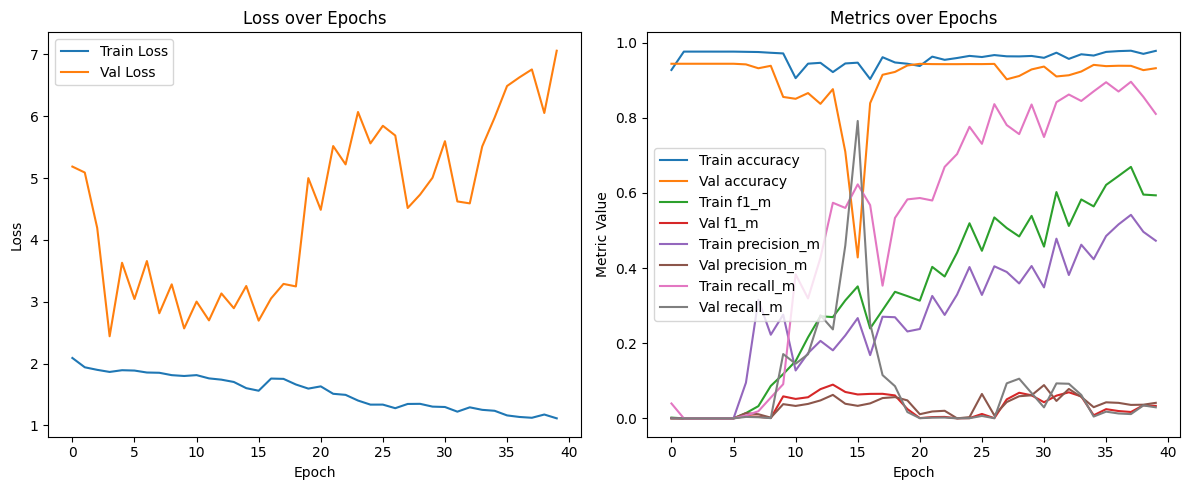

In [632]:
plot_training_history(history)

In [633]:
#more complex neigbor prediction funtion

from scipy.ndimage import convolve

def neighborhood_filter(pred_mask, threshold=0.5, required_fraction=0.5):
    binary = (pred_mask > threshold)

    kernel = np.ones((4, 4))  # 8-neighborhood
    neighbor_count = convolve(binary, kernel, mode='constant', cval=0.0)

    # Require at least required_fraction of neighbors to also be fire
    return ((binary == 1) & (neighbor_count >= (4*4 * required_fraction)))


In [634]:
#plot results


def PlotPredictions(start,end,label,prediction):
  """
  plots pairs of images, one for the actual fire mask, and the next for the predicted firemask from our model.

  Args:
  start (int): the index of the first firemask to use
  end (int): the index of the last fire mask to use, non-inclusive
  label: the actual fire mask
  prediction: the predicted fire mask from the model
  """
    
  n_plots = end - start
  fig, axes = plt.subplots(n_plots, 2, figsize=(12, 4 * n_plots))
  # norm2 = colors.Normalize(vmin=0, vmax=1)  


  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


  for i in range(n_plots):
    #actual fire mask
    axes[i,0].imshow(label[i+start,:,:,0],cmap=CMAP,norm=NORM)
    axes[i, 0].set_title(f"Actual Fire Mask {i + start} ")
    axes[i, 0].axis('off')

    #handles prediction, each prediction has a vector of [p_noFire,p_fire], we will use whatever one is larger
    axes[i,1].imshow(prediction[start+i,:,:]>.5,cmap=CMAP,norm=NORM)
    axes[i, 1].set_title(f"predicted Fire Mask {i + start}")
    axes[i, 1].axis('off')

  plt.tight_layout()
  plt.show()


def show_preds(inputs, labels, preds, index=0):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(inputs[index, :, :, -1], cmap='gray')
    axs[0].set_title("Previous Fire Mask")
    
    axs[1].imshow(labels[index, :, :, 0], cmap='Reds')
    axs[1].set_title("True Fire Mask")

    axs[2].imshow(preds[index, :, :, 0], cmap='Oranges')
    axs[2].set_title("Predicted Fire Prob.")
    
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


  

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step


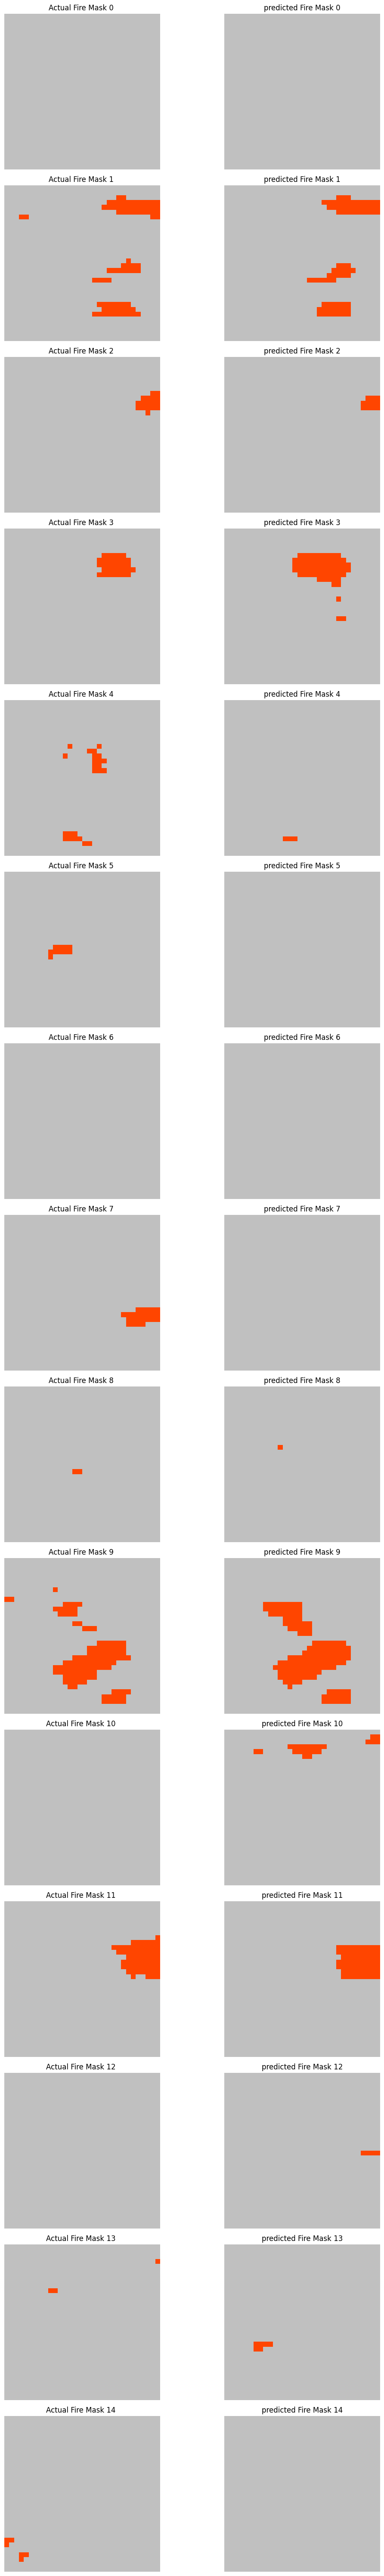

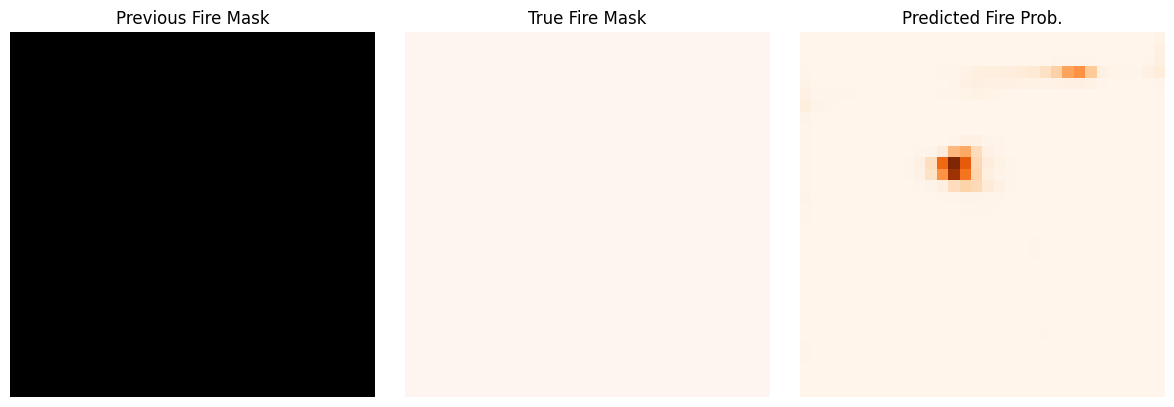

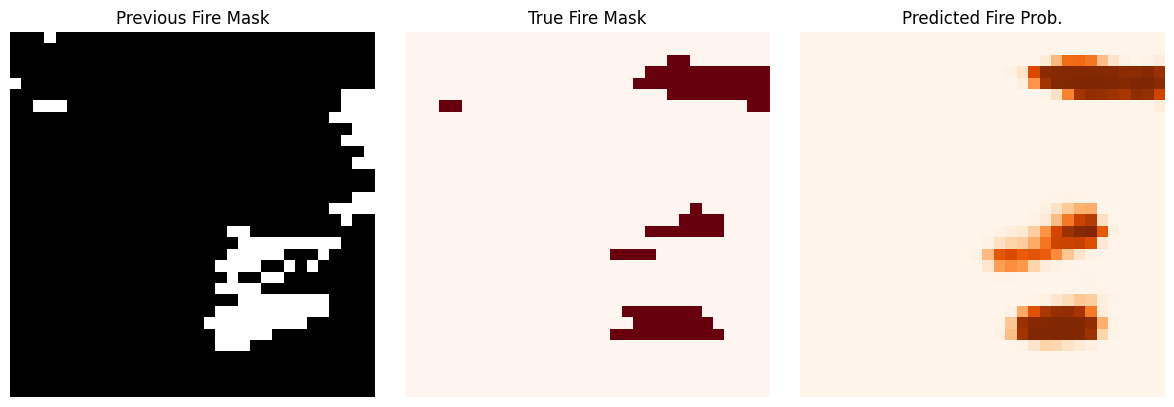

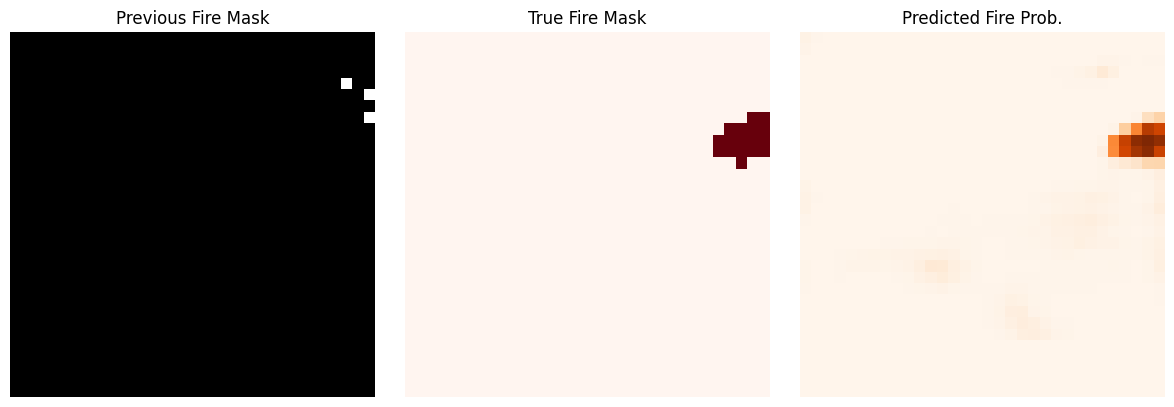

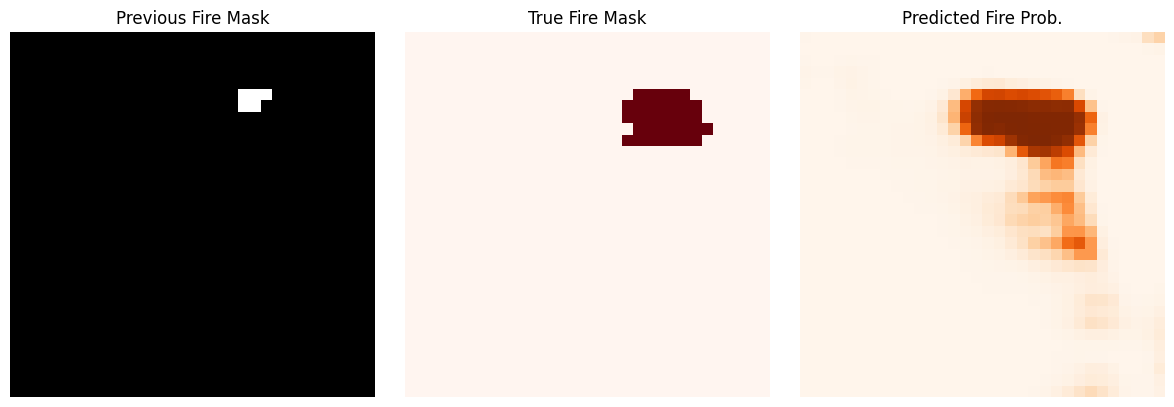

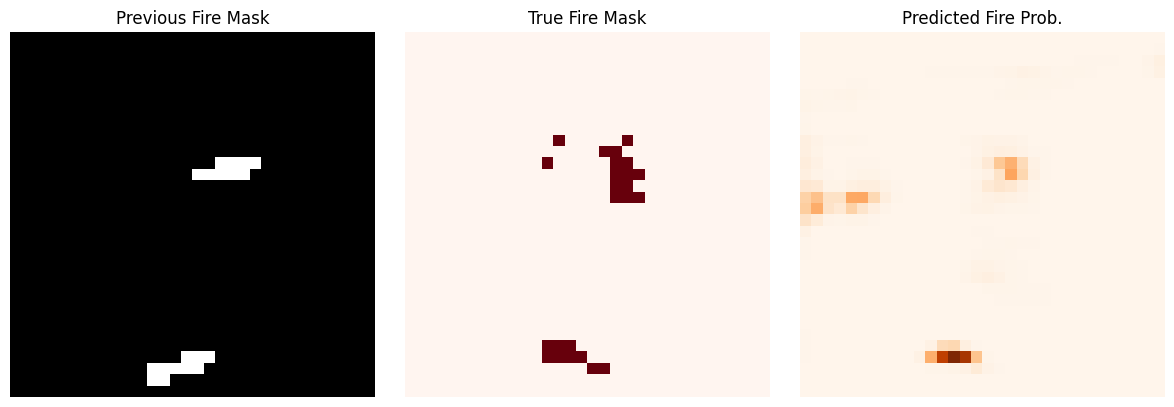

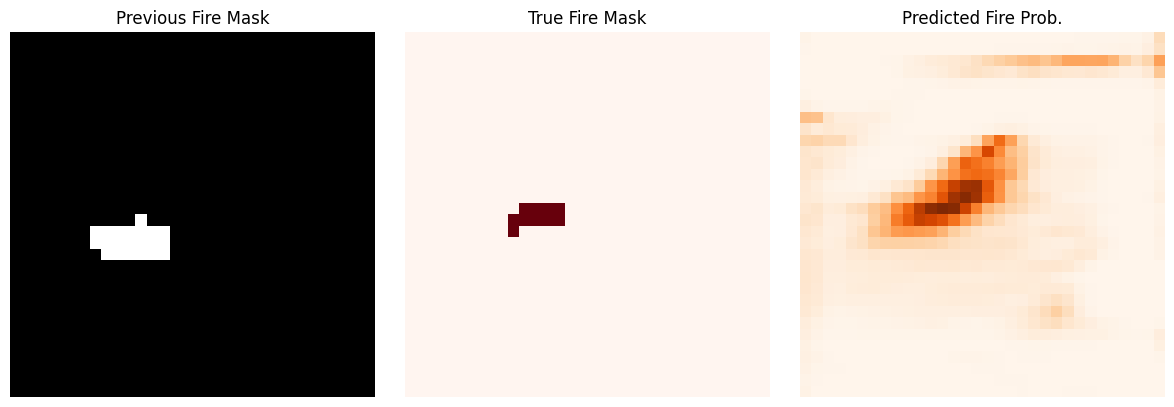

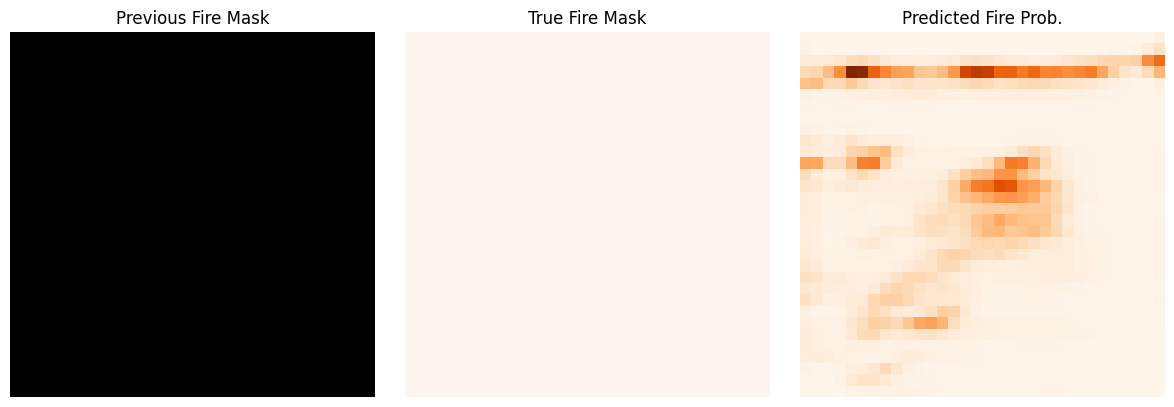

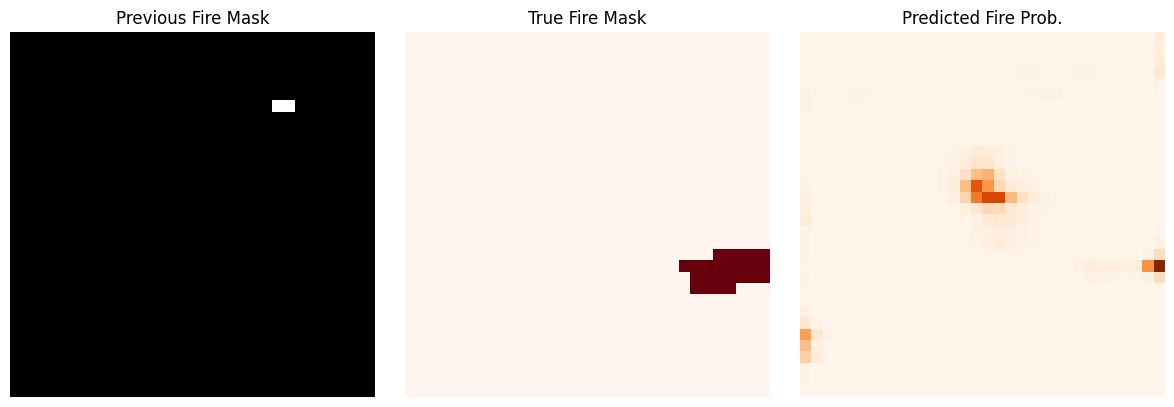

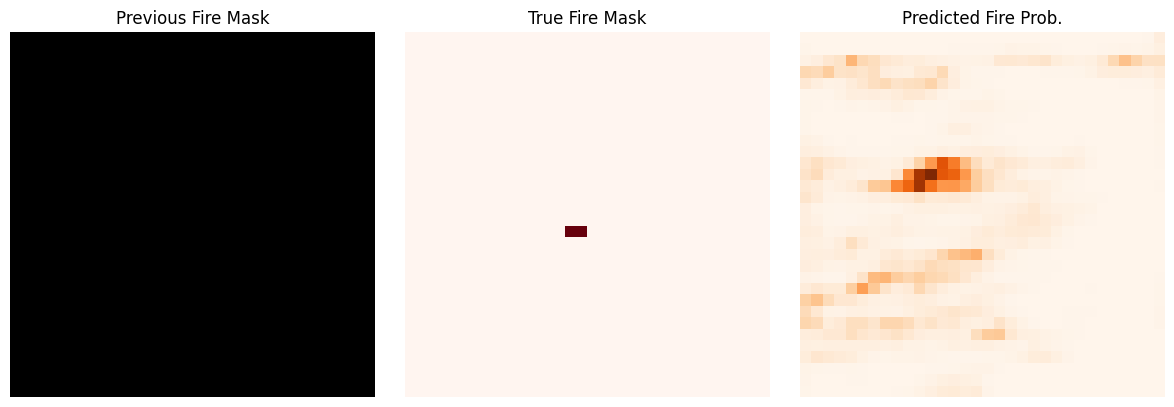

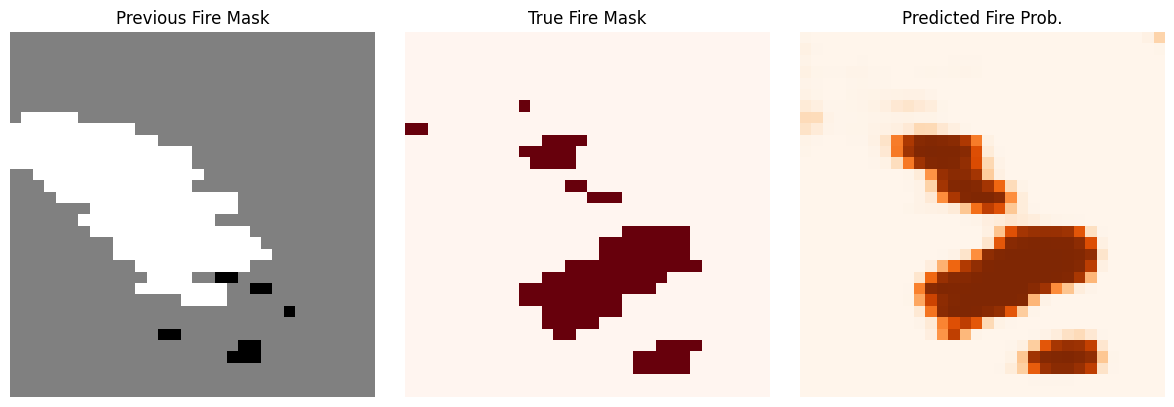

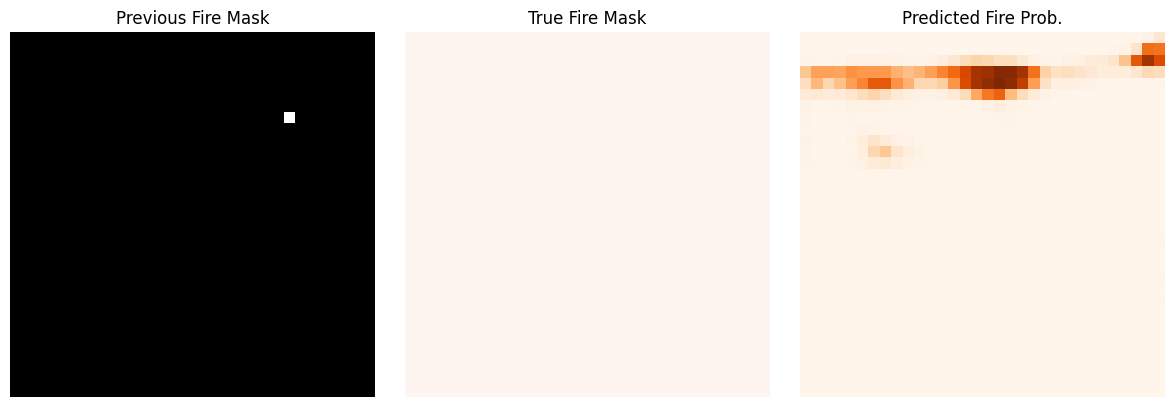

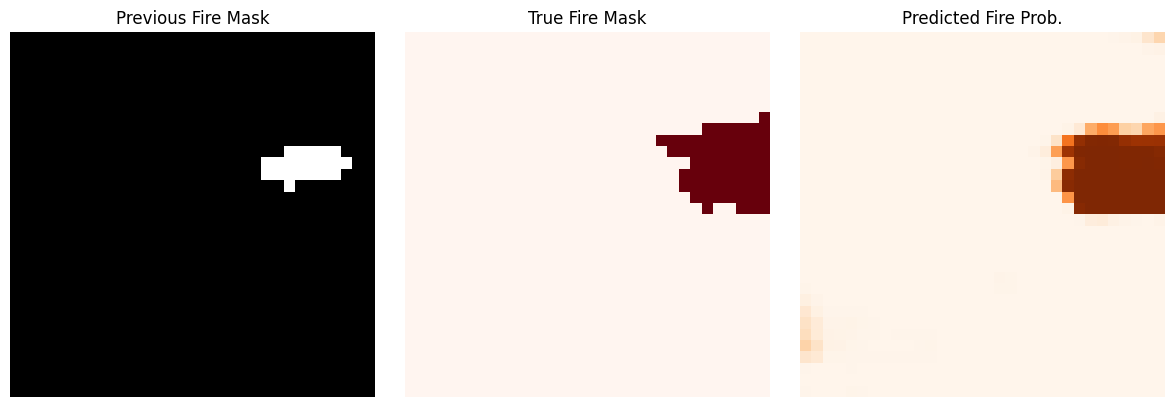

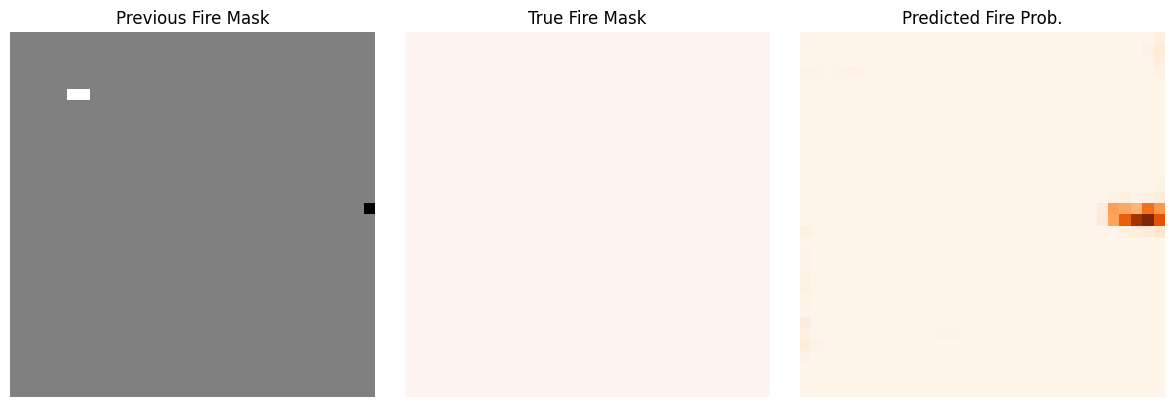

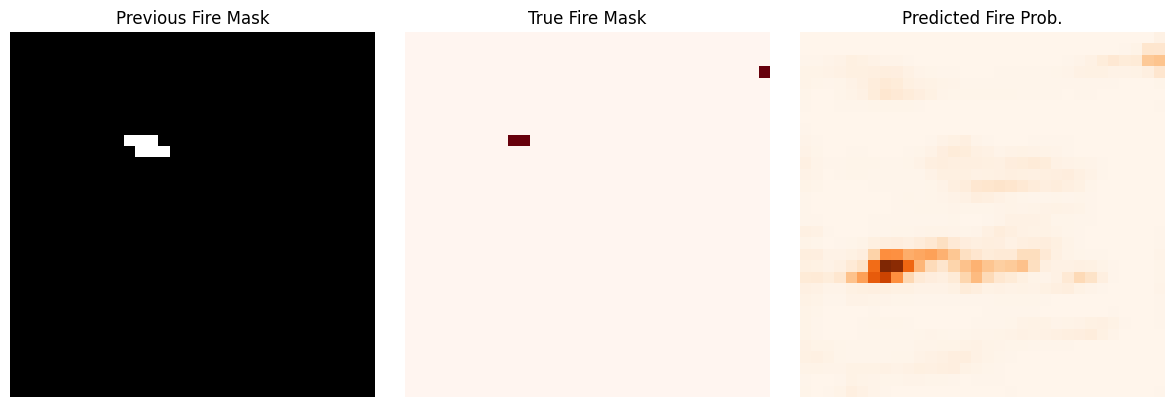

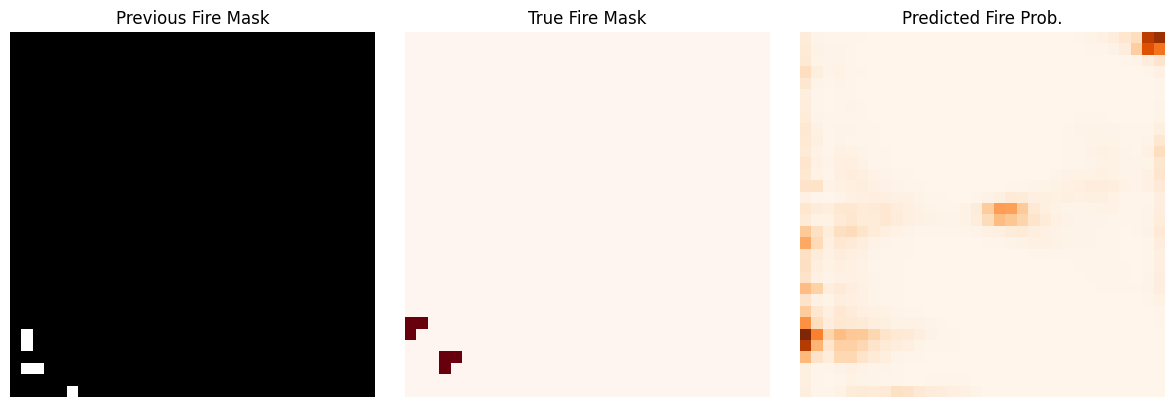

In [635]:
pMask = model.predict(inputs)


#apply neigborhood filtering

# filtered_preds = np.array([
#     neighborhood_filter(mask, threshold=0.2, required_fraction=0.2)
#     for mask in pMask[:,:,:,0]
# ])


# plotRows(0,5,titles,len(titles)-1, train)
PlotPredictions(0,15,labels,pMask)
# PlotPredictions(0,15,labels,filtered_preds)
for i in range(15):
    show_preds(inputs,labels,pMask,index = i)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


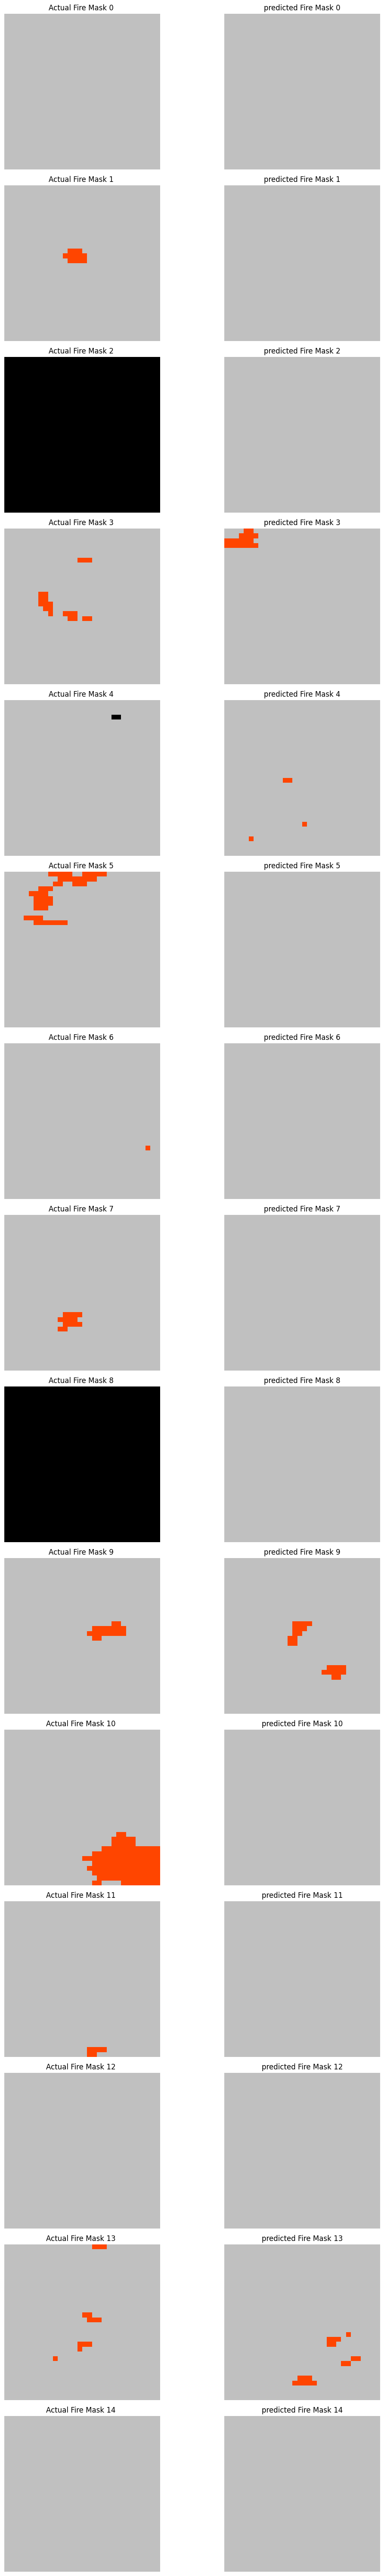

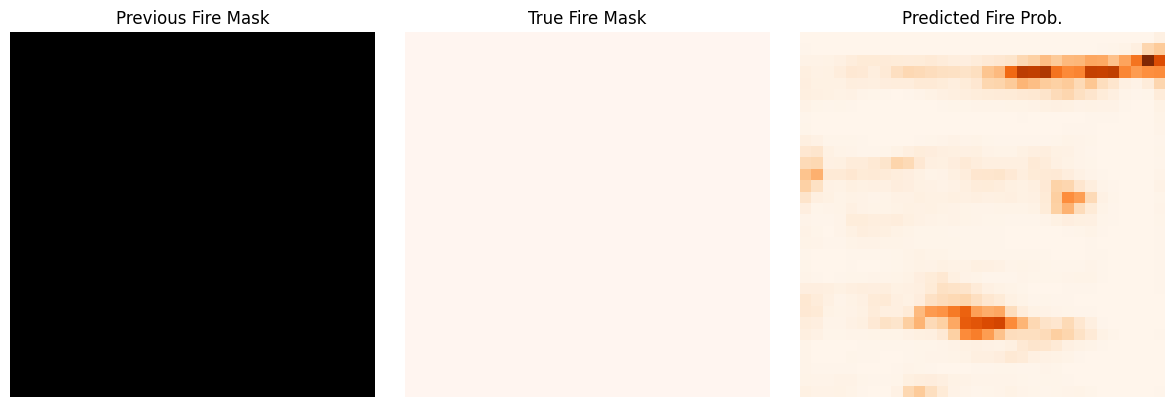

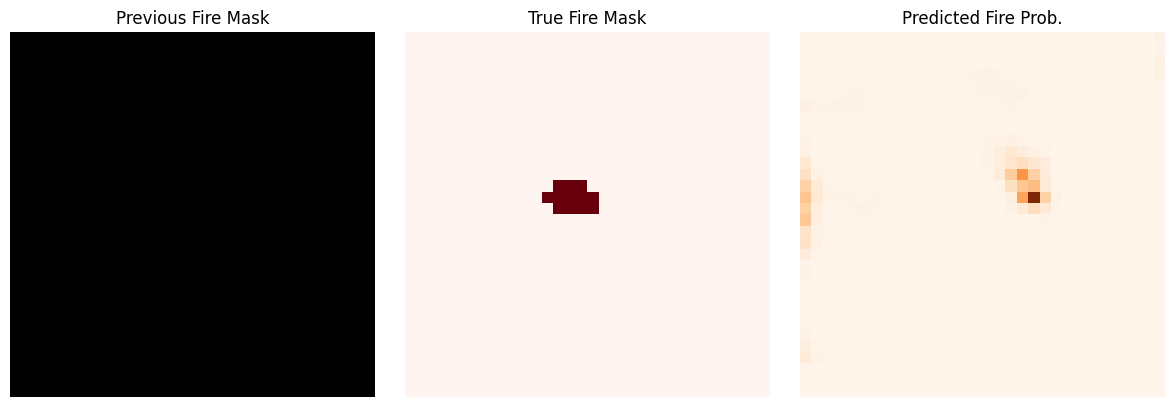

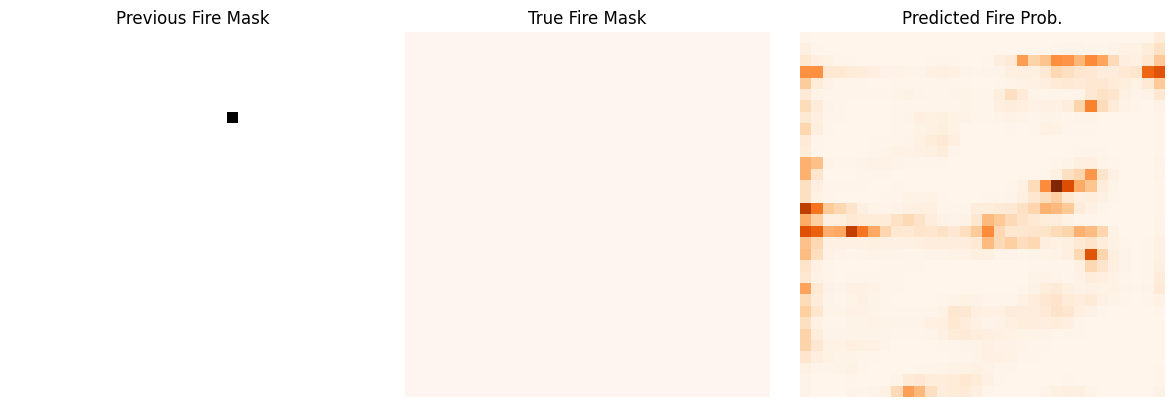

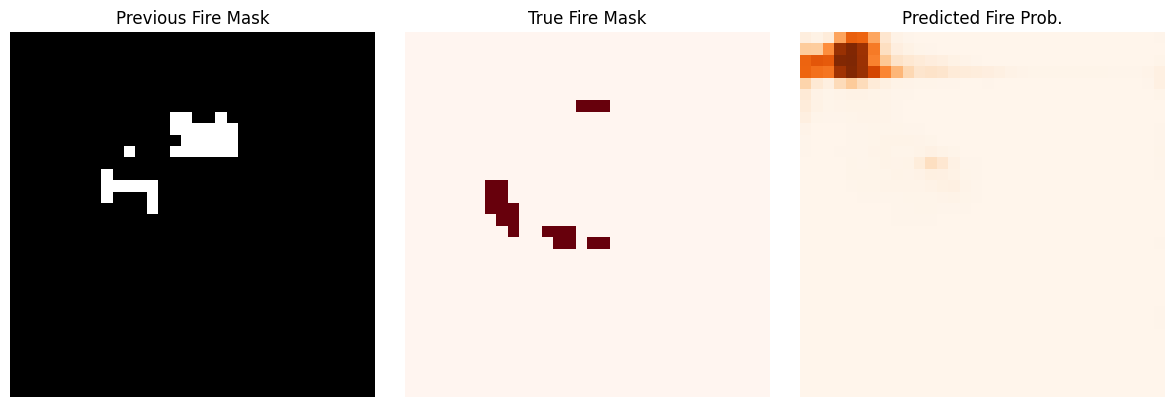

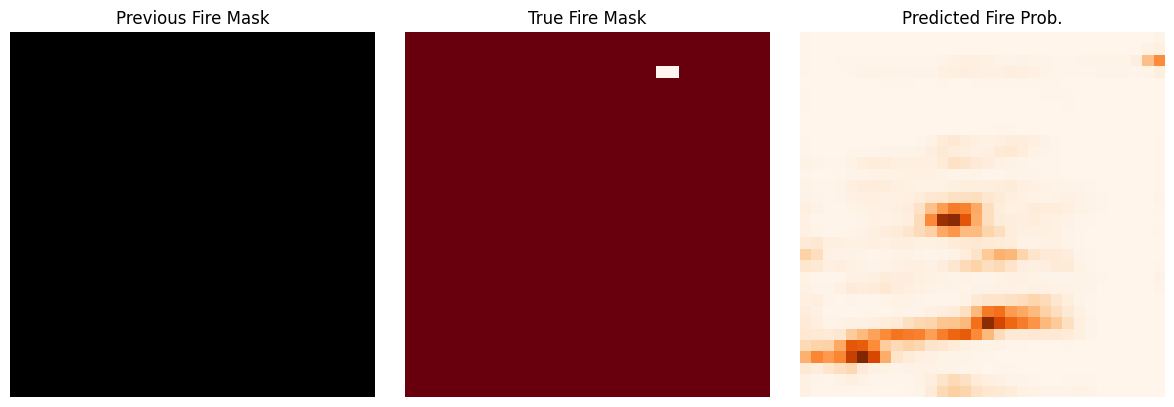

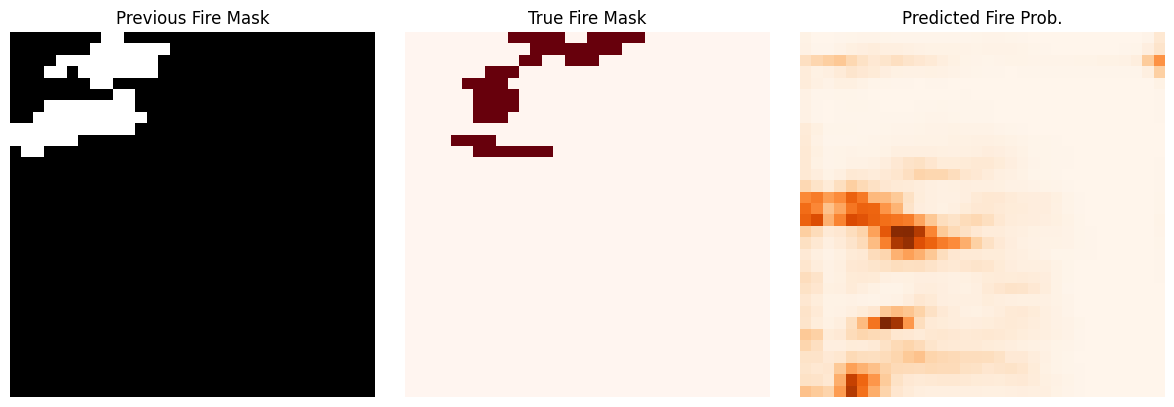

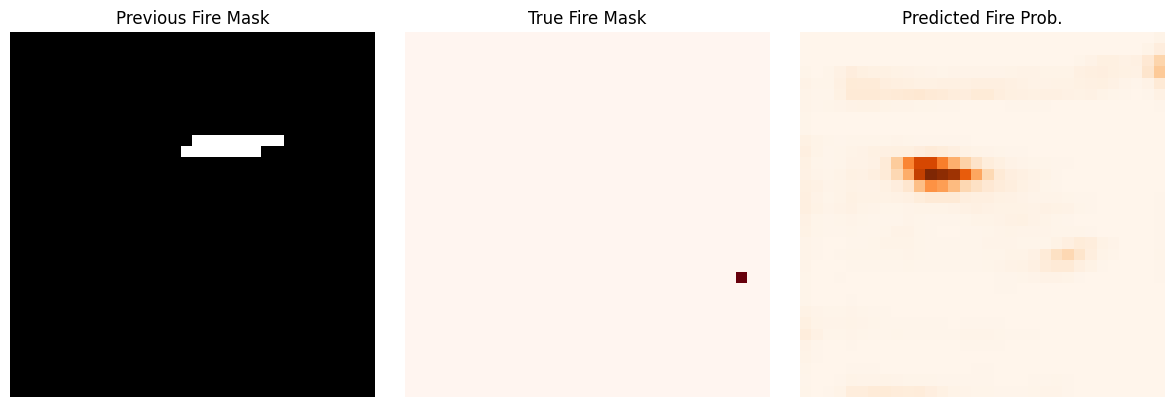

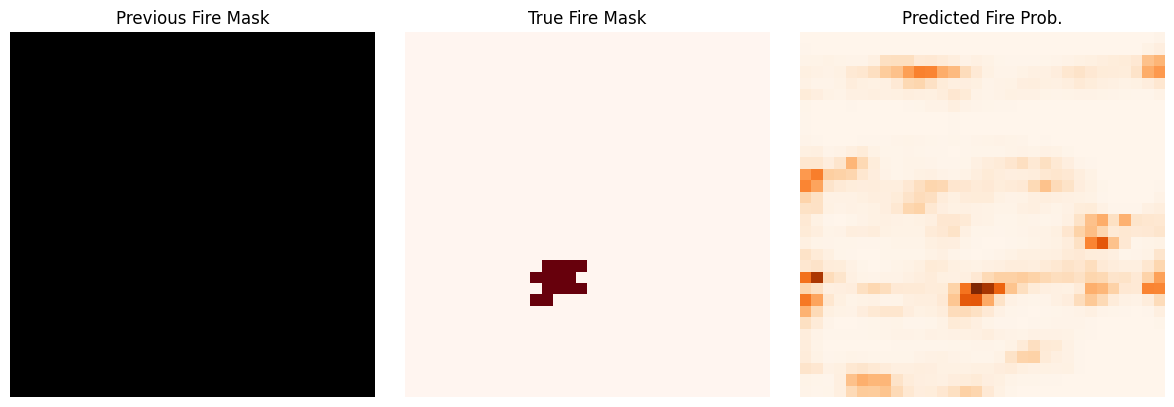

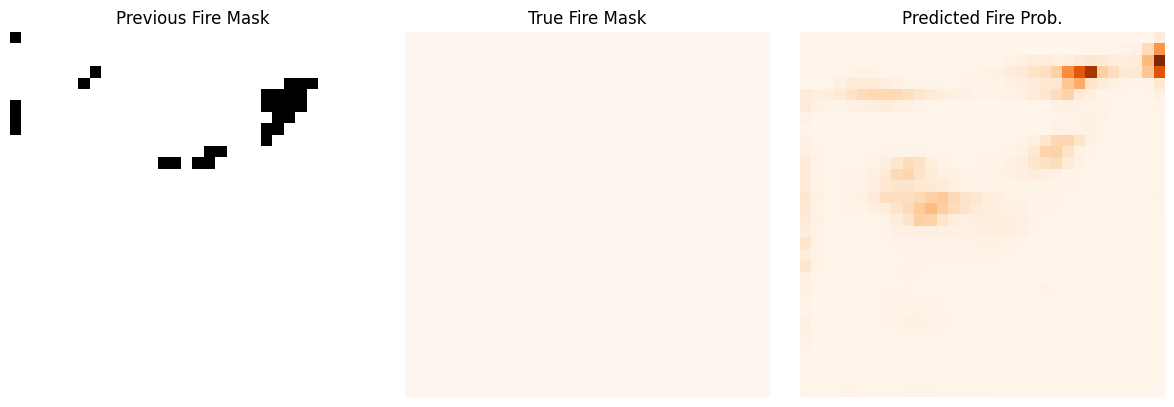

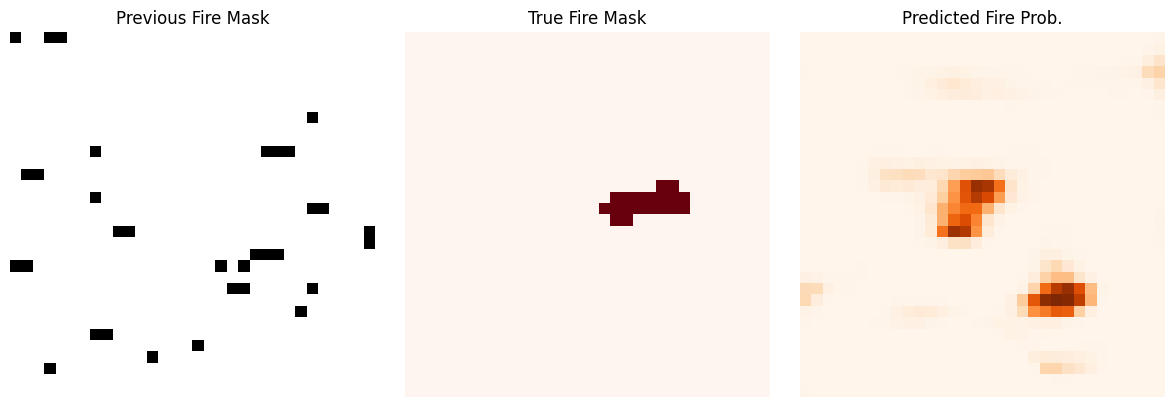

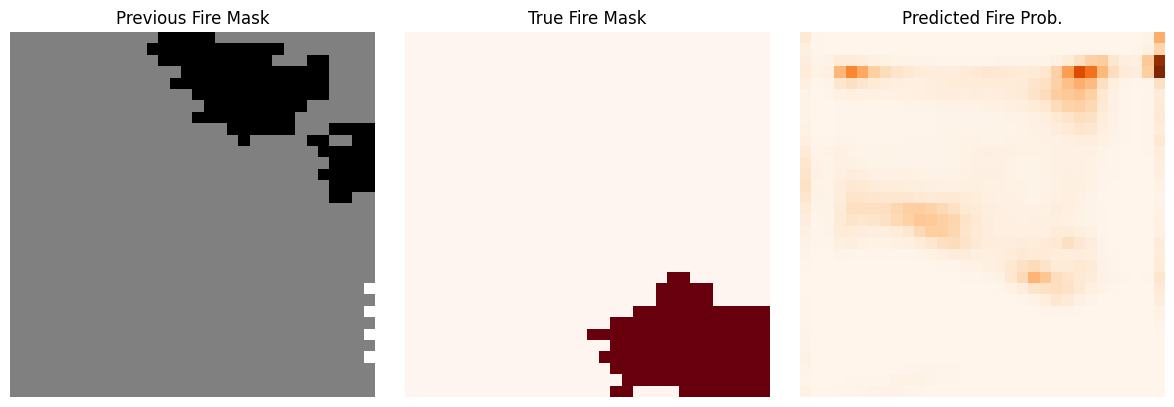

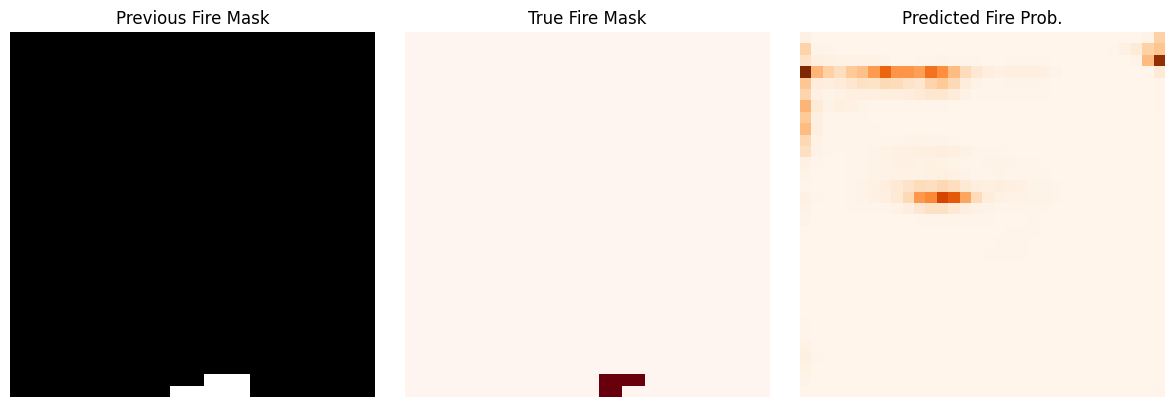

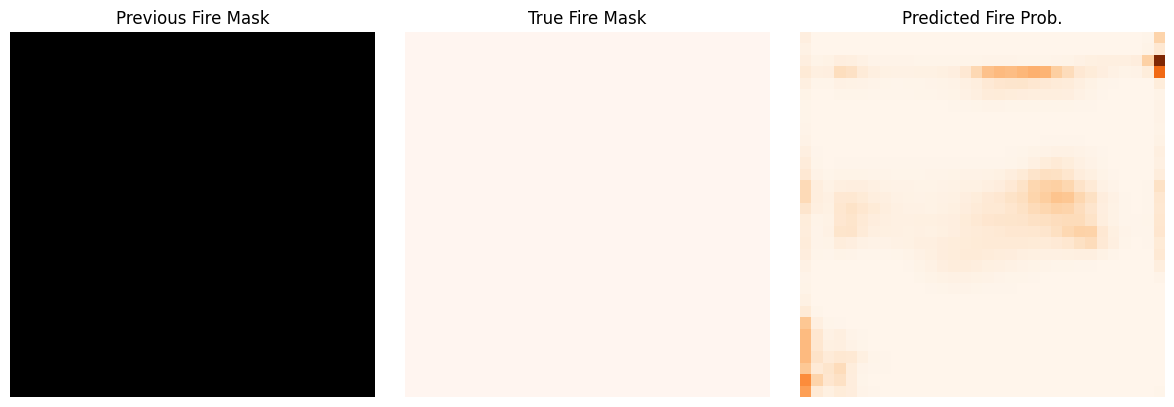

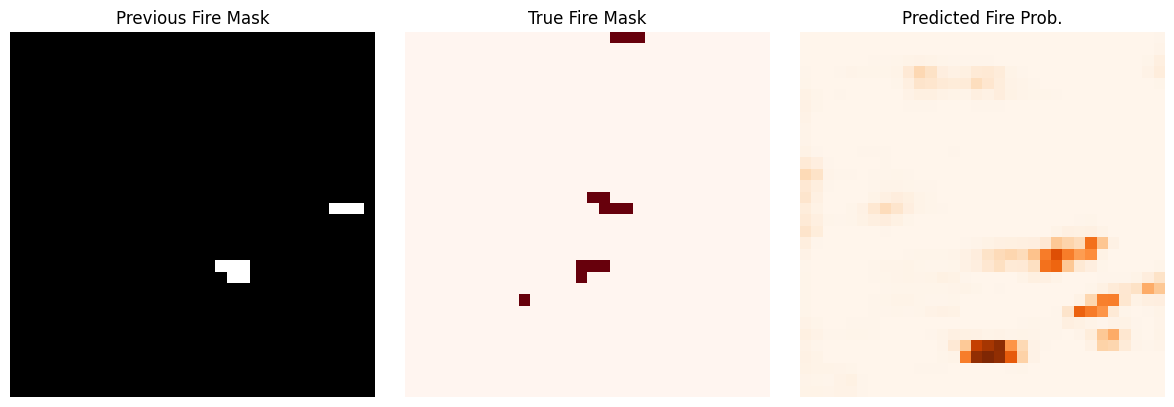

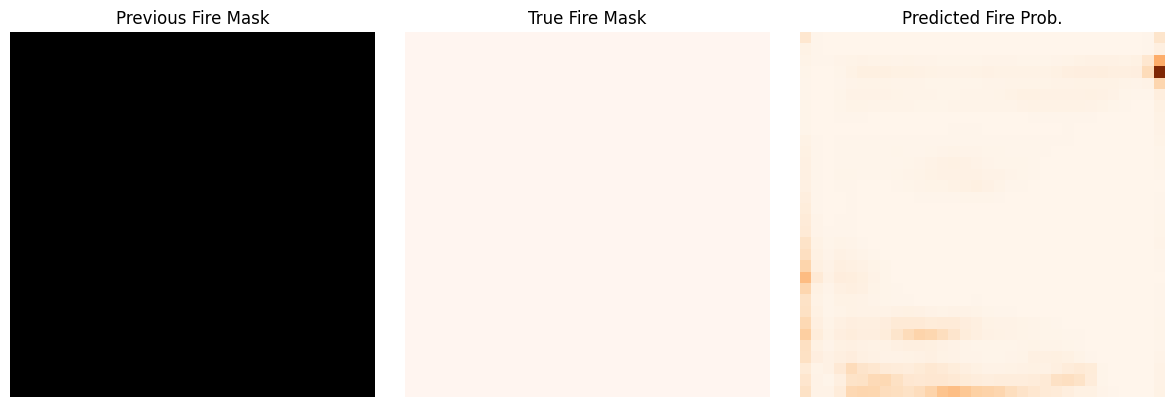

In [636]:
pMask_eval = model.predict(e_inputs)

PlotPredictions(0,15,e_labels,pMask_eval)
# PlotPredictions(0,15,labels,filtered_preds)
for i in range(15):
    show_preds(e_inputs,e_labels,pMask_eval,index = i)